## HT 3

Разработать систему мониторинга и алертинга для обнаружения различных типов дрифта в временных рядах метрик веб-сервиса. Найти истинные дрифты с минимальным количеством false алертов.

In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
%reload_ext autoreload

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from collections import defaultdict, Counter
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [4]:

def visualize_generated_data(df, true_drifts):
    """
    Визуализация данных с отметками истинных дрифтов
    """
    metrics = ['requests', 'response_time', 'error_rate', 'cpu_usage']
    titles = [
        'Requests per Hour (drift at 700)',
        'Response Time ms (drifts at 500, 800)',
        'Error Rate % (drift at 600)',
        'CPU Usage % (drift at 750)'
    ]

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    for idx, (metric, title, ax) in enumerate(zip(metrics, titles, axes)):
        ax.plot(df.index, df[metric], linewidth=1, alpha=0.7, label='Data')

        # Отметки истинных дрифтов
        for drift_point in true_drifts[metric]:
            ax.axvline(x=drift_point, color='red', linestyle='--',
                      linewidth=2, alpha=0.7, label='True Drift' if drift_point == true_drifts[metric][0] else '')

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [5]:
df = pd.read_csv('drifts.csv')
df['idx'] = range(df.shape[0])
df = df.set_index('timestamp')

In [6]:
true_drifts = {
    'requests': [700],
    'response_time': [500, 800],
    'error_rate': [600],
    'cpu_usage': [750]
}

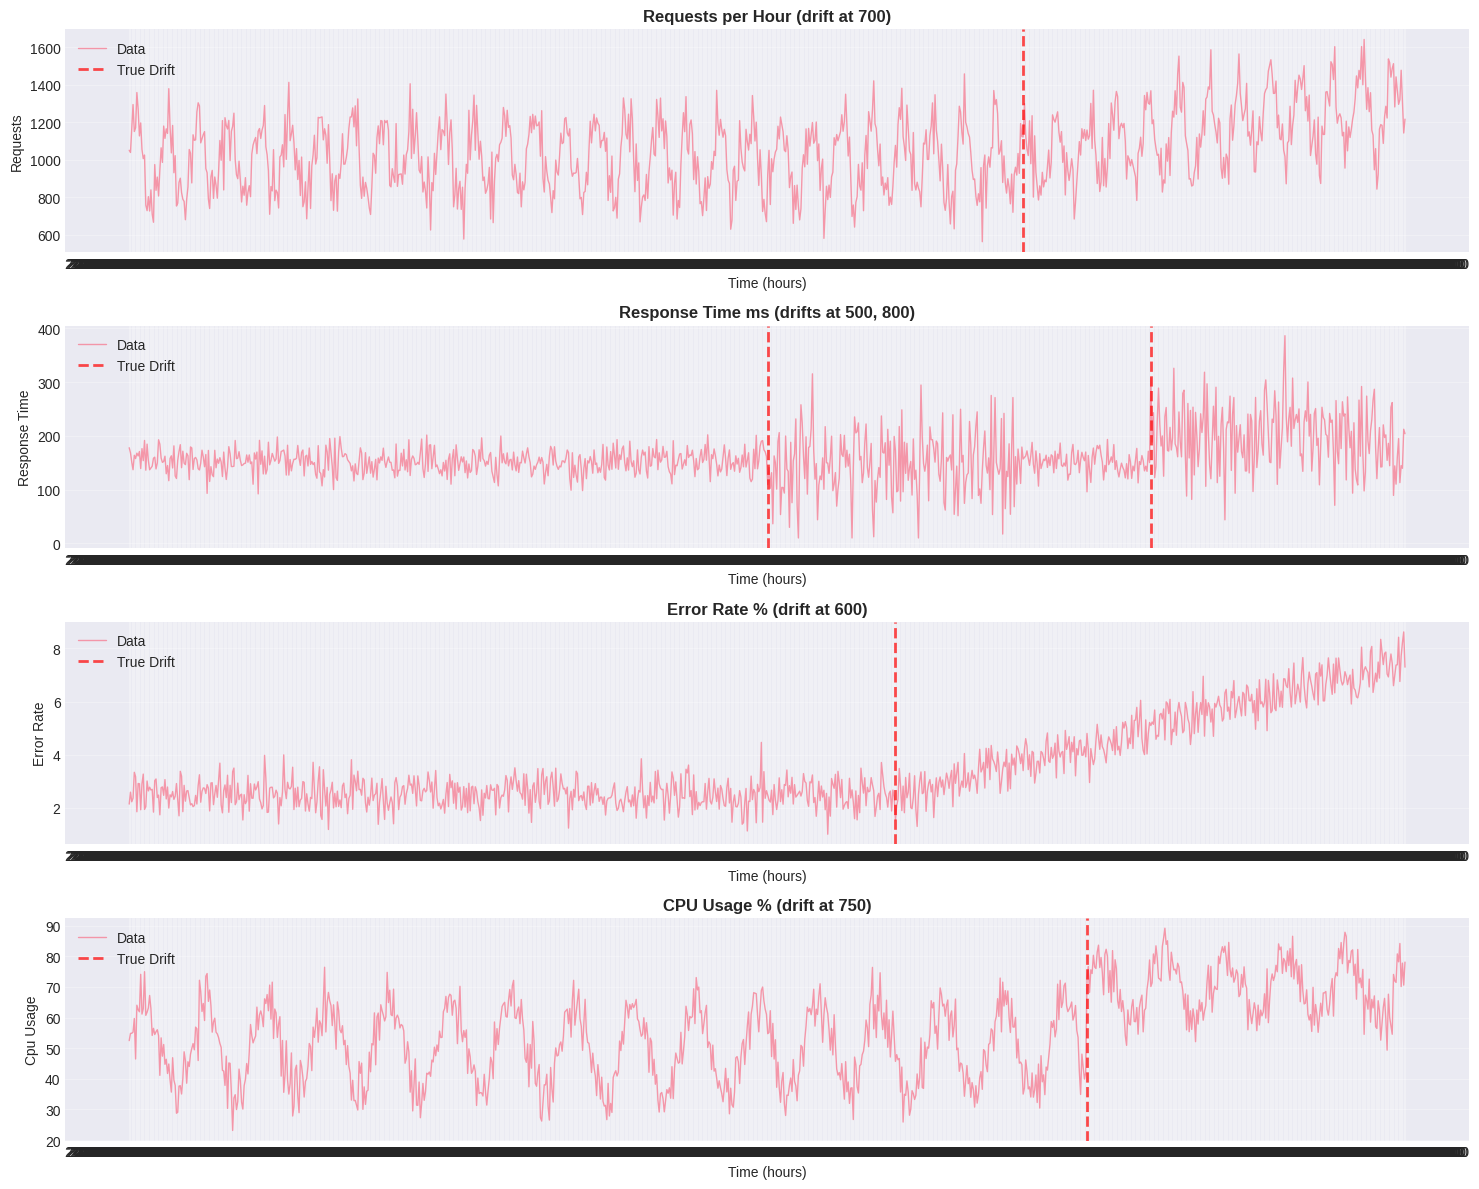

In [7]:
visualize_generated_data(df, true_drifts)

Исходные данные уже имеют метки истинных дрифтов, ваша задача - написать код, который с одной стороны определяет их как можно раньше, с другой стороны генерирует низкое количество ложных алеротов.

#### Задание 1

Выберите размеры окон и референсные периоды, реализуйте детекторы дрифта.

In [8]:
# 2. Детекторы дрифта
from hw3 import DriftDetector

In [9]:
def estimate_period_acf(
    s: pd.Series,
    min_lag: int = 6,
    max_lag: int = 72,
    window: int = 24*14,
) -> int:
    x = s.astype(float).to_numpy()
    w = min(window, len(x))
    xw = pd.Series(x[:w]).interpolate(limit_direction="both").to_numpy()
    xw = xw - np.nanmean(xw)

    best_p, best_score = min_lag, -np.inf
    for p in range(min_lag, max_lag + 1):
        if w <= p + 5:
            continue
        a, b = xw[p:], xw[:-p]
        denom = (np.nanstd(a) * np.nanstd(b))
        score = (np.nanmean(a * b) / denom) if denom > 1e-12 else -np.inf
        if score > best_score:
            best_score, best_p = score, p

        # print(p, score)
    return best_p


In [13]:
for f in true_drifts:
    print(f, estimate_period_acf(df[f], 10, 72, 24 * 7 ))

requests 48
response_time 71
error_rate 67
cpu_usage 48


#### Задание 2

Реализуйте логику алертов на основе дрифт детекторов, настройте пороги срабатывания

In [291]:
from hw3 import AlertSystem, MetricConfig


configs = {
    "requests": MetricConfig(
        name="requests",
        period=24*2,
        window_size=24,
        reference_window_size=24*7,
        ks_threshold=0.01,
        psi_threshold=0.3,
        persistence=2,
        cooldown=24,
        min_features_to_alert=1,
        features=["roll_mean",],
        mde=0.01,

        # trend drift
        detect_trend_drift=True,
        trend_source="roll_mean",
        trend_rolling_window=24*3,
        trend_window_size=24*4,
        trend_reference_window_size=24*7,
        trend_ks_threshold=0.01,
        trend_psi_threshold=0.35,
        trend_mde=0.5,
        trend_persistence=5,
        trend_cooldown=24 * 2,
        
    ),
    "response_time": MetricConfig(
        name="response_time",
        period=24,
        window_size=28,
        reference_window_size=28,
        ks_threshold=0.01,
        psi_threshold=0.35,
        persistence=5,
        cooldown=24,
        min_features_to_alert=1,
        features=["roll_std"],
        mde=0.3,
    ),
    "error_rate": MetricConfig(
        name="error_rate",
        period=24,
        window_size=24,
        reference_window_size=24*7,
        ks_threshold=0.05,
        psi_threshold=0.35,
        persistence=3,
        cooldown=24,
        min_features_to_alert=1,
        features=["q95"],
        mde=0.01,

        # trend drift
        detect_trend_drift=True,
        trend_source="roll_mean",
        trend_rolling_window=24*3,
        trend_window_size=24*4,
        trend_reference_window_size=24*7,
        trend_ks_threshold=0.01,
        trend_psi_threshold=0.35,
        trend_mde=0.01,
        trend_persistence=5,
        trend_cooldown=24 * 2,
    ),
    "cpu_usage": MetricConfig(
        name="cpu_usage",
        period=48,                    # 2-дневная сезонность
        window_size=48,
        reference_window_size=48*2,
        ks_threshold=0.01,
        psi_threshold=0.3,
        persistence=3,
        cooldown=24,
        min_features_to_alert=2,
        features=["roll_median", "one_step_resid"],
        mde=0.03,

        # trend drift
        detect_trend_drift=True,
        trend_source="roll_mean",
        trend_rolling_window=24*3,
        trend_window_size=24*4,
        trend_reference_window_size=24*7,
        trend_ks_threshold=0.01,
        trend_psi_threshold=0.35,
        trend_mde=0.1,
        trend_persistence=5,
        trend_cooldown=24 * 2,
    ),
}

alerter = AlertSystem(configs, timestamp_col="timestamp")


In [296]:
alerts = alerter.detect(df)

In [297]:
alerts.shape

(7, 11)

In [274]:
# alerts_trend = alerter.detect_trend_drift(df, False)

#### Задание 3

Оцените качество полученного решения и визуализируйте алерты.

In [161]:
from hw3 import evaluate_alerts, plot_results

In [300]:
for m in true_drifts:

    res = evaluate_alerts(
        true_drifts[m],
        alerts[alerts.metric == m].idx.tolist(),
        tolerance=40
    )
    print(f"{m}:")
    print('recall', res['recall'], 'fpr', res['fpr'])

requests:
recall 1.0 fpr 0.0
response_time:
recall 1.0 fpr 0.0
error_rate:
recall 1.0 fpr 0.5
cpu_usage:
recall 1.0 fpr 0.5


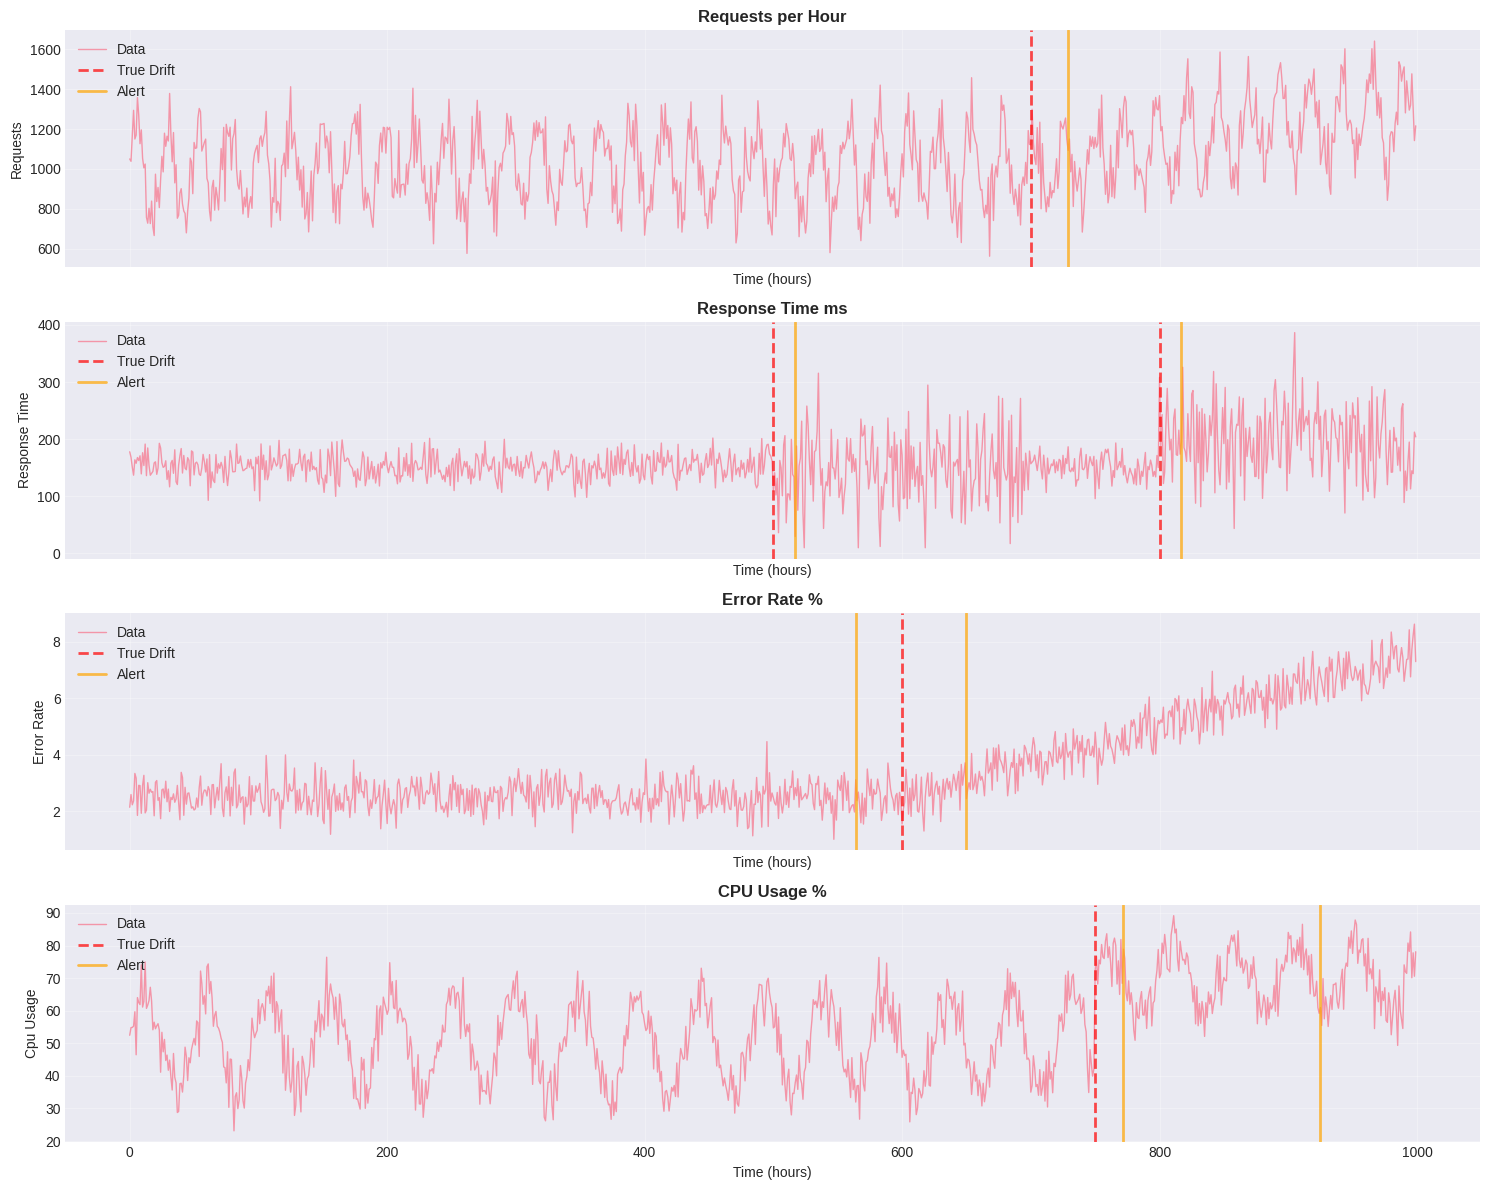

In [299]:
plot_results(df, alerts, true_drifts=true_drifts)

#### Изучение признаков

In [740]:
import pandas as pd

from hw3 import build_features

METRICS = ["requests", "response_time", "error_rate", "cpu_usage"]

def compute_all_features(
    df: pd.DataFrame,
    *,
    metric_params: dict,
) -> dict:
    features_by_metric = {}
    for m in METRICS:
        if m not in df.columns:
            continue
        p = metric_params[m]
        features_by_metric[m] = build_features(
            df[m],
            period=p["period"],
            window_size=p["window_size"],
            reference_window_size=p["reference_window_size"],
        )
    return features_by_metric

import math


def plot_metric_features(
    features_df: pd.DataFrame,
    *,
    metric_name: str,
    feature_cols: list,
    ncols: int = 2,
    figsize_per_plot: tuple = (7, 2.6),
):
    cols = [c for c in feature_cols if c in features_df.columns]
    if not cols:
        raise ValueError("Нет подходящих feature_cols в features_df")

    n = len(cols)
    nrows = math.ceil(n / ncols)

    fig_w = figsize_per_plot[0] * ncols
    fig_h = figsize_per_plot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), sharex=True)
    axes = axes.flatten() if n > 1 else [axes]

    x = range(len(features_df))

    for i, col in enumerate(cols):
        ax = axes[i]
        ax.plot(x, features_df[col].values, linewidth=1, alpha=0.8)
        ax.set_title(f"{metric_name}: {col}", fontsize=11, fontweight="bold")
        ax.grid(True, alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    axes[min(len(axes)-1, i)].set_xlabel("Time (hours)")
    plt.tight_layout()
    plt.show()



In [741]:
metric_params = {
    "requests": {"period": 24 * 2, "window_size": 24 * 2, "reference_window_size": 24*7},
    "response_time": {"period": 24, "window_size": 24, "reference_window_size": 24*3},
    "error_rate": {"period": 24, "window_size": 24, "reference_window_size": 24*7},
    "cpu_usage": {"period": 48, "window_size": 48, "reference_window_size": 24*7},
}

features_by_metric = compute_all_features(df, metric_params=metric_params)

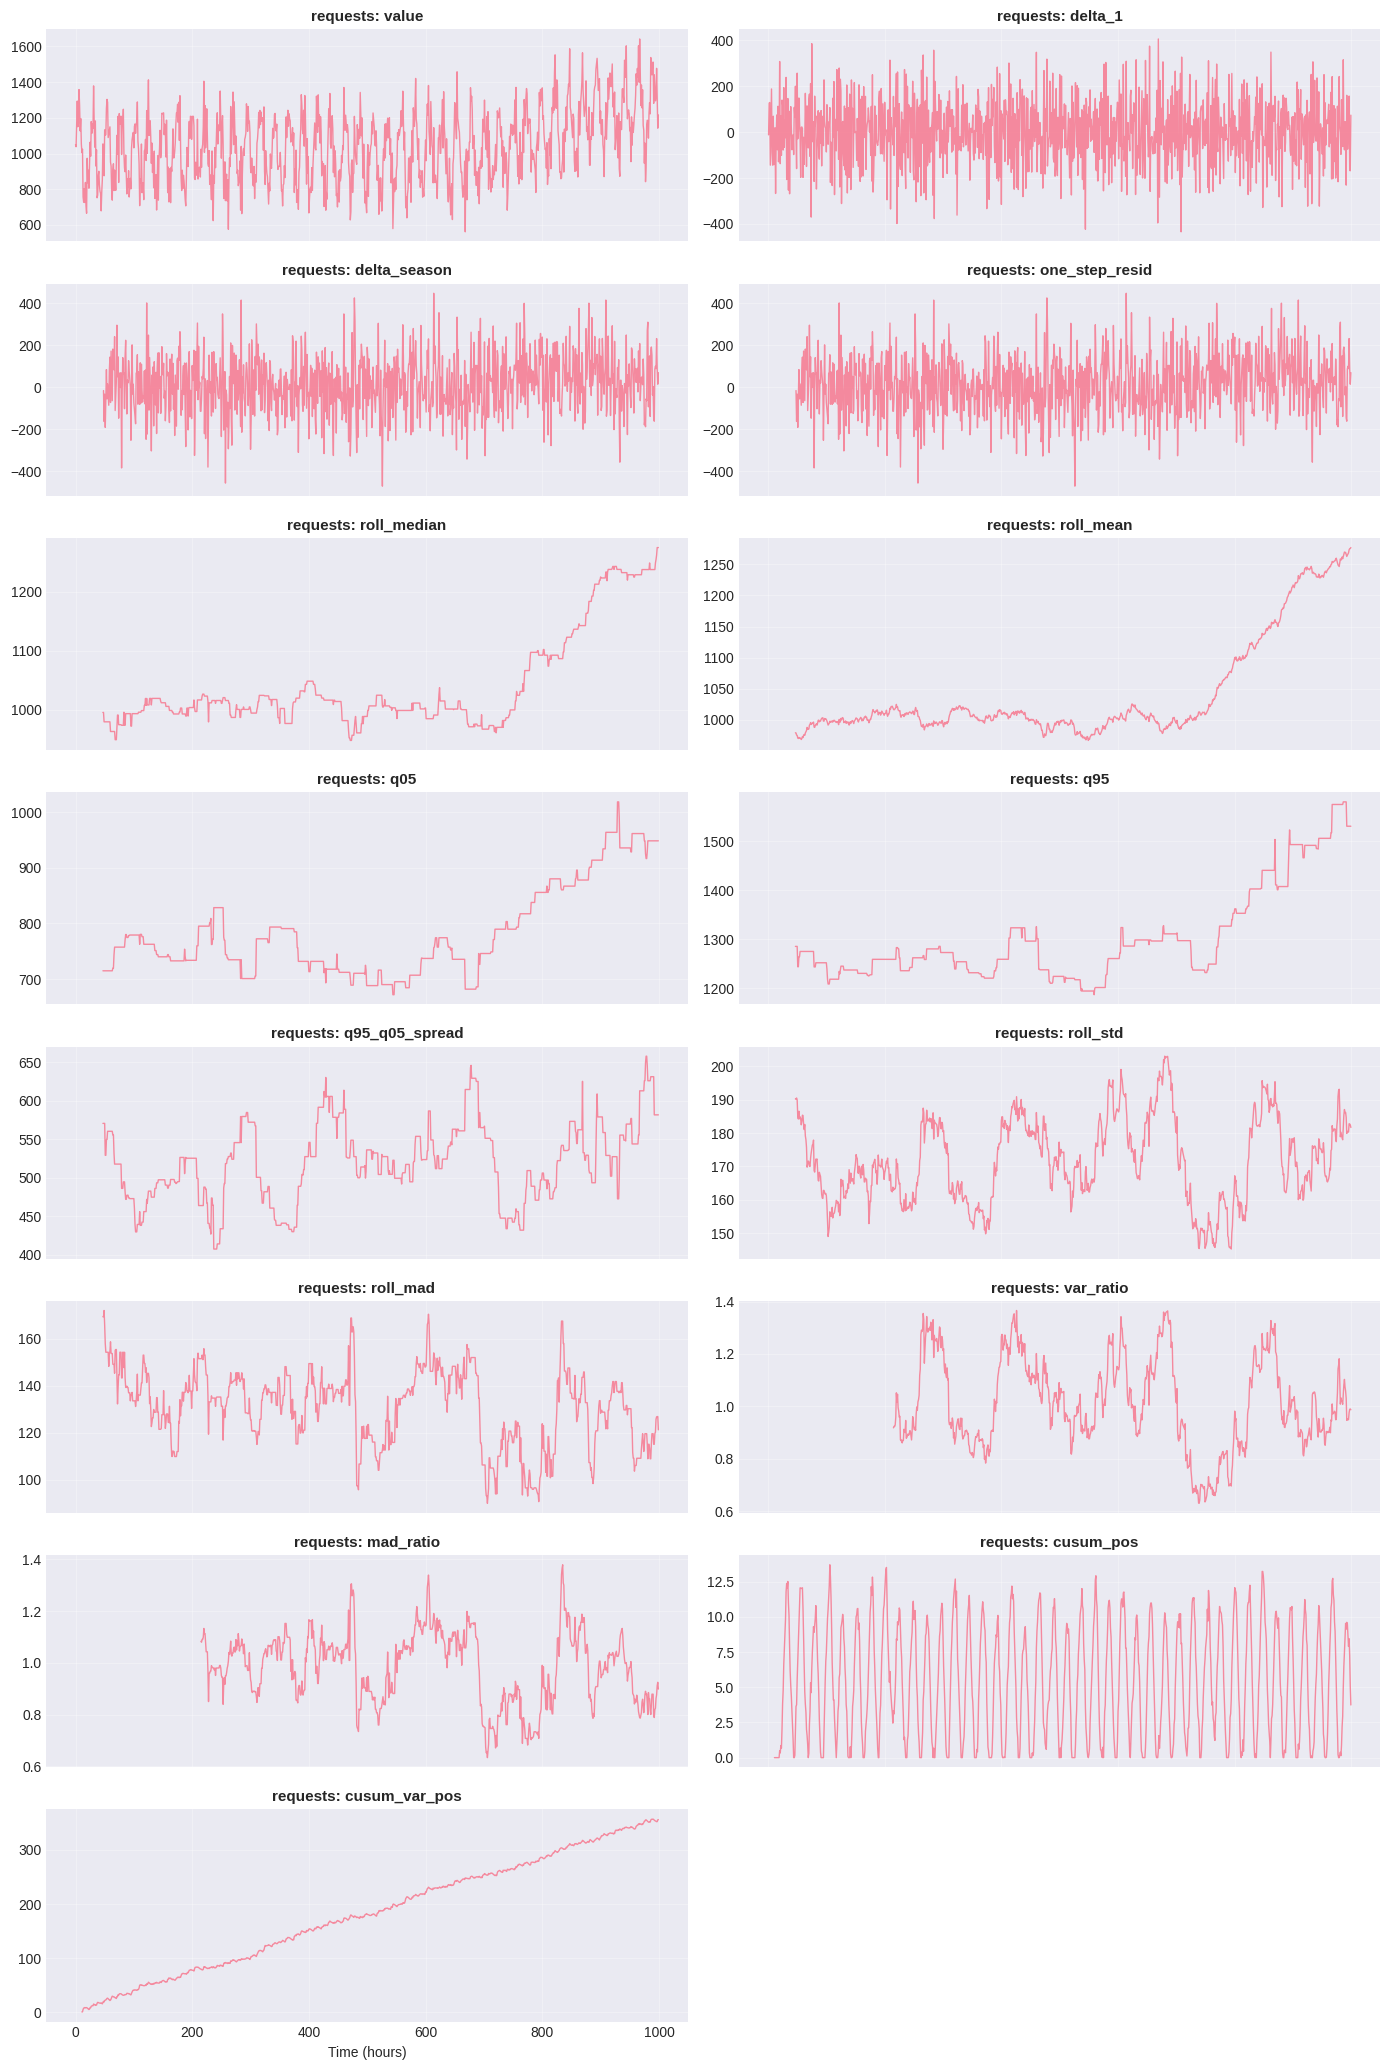

In [742]:
DEFAULT_FEATURES = [
    "value", "delta_1", "delta_season", "one_step_resid",
    "roll_median", "roll_mean",
    "q05", "q95", "q95_q05_spread",
    "roll_std", "roll_mad",
    "var_ratio", "mad_ratio",
    "cusum_pos",
    "cusum_var_pos"
]

plot_metric_features(
    features_by_metric["requests"],
    metric_name="requests",
    feature_cols=DEFAULT_FEATURES,
    ncols=2
)

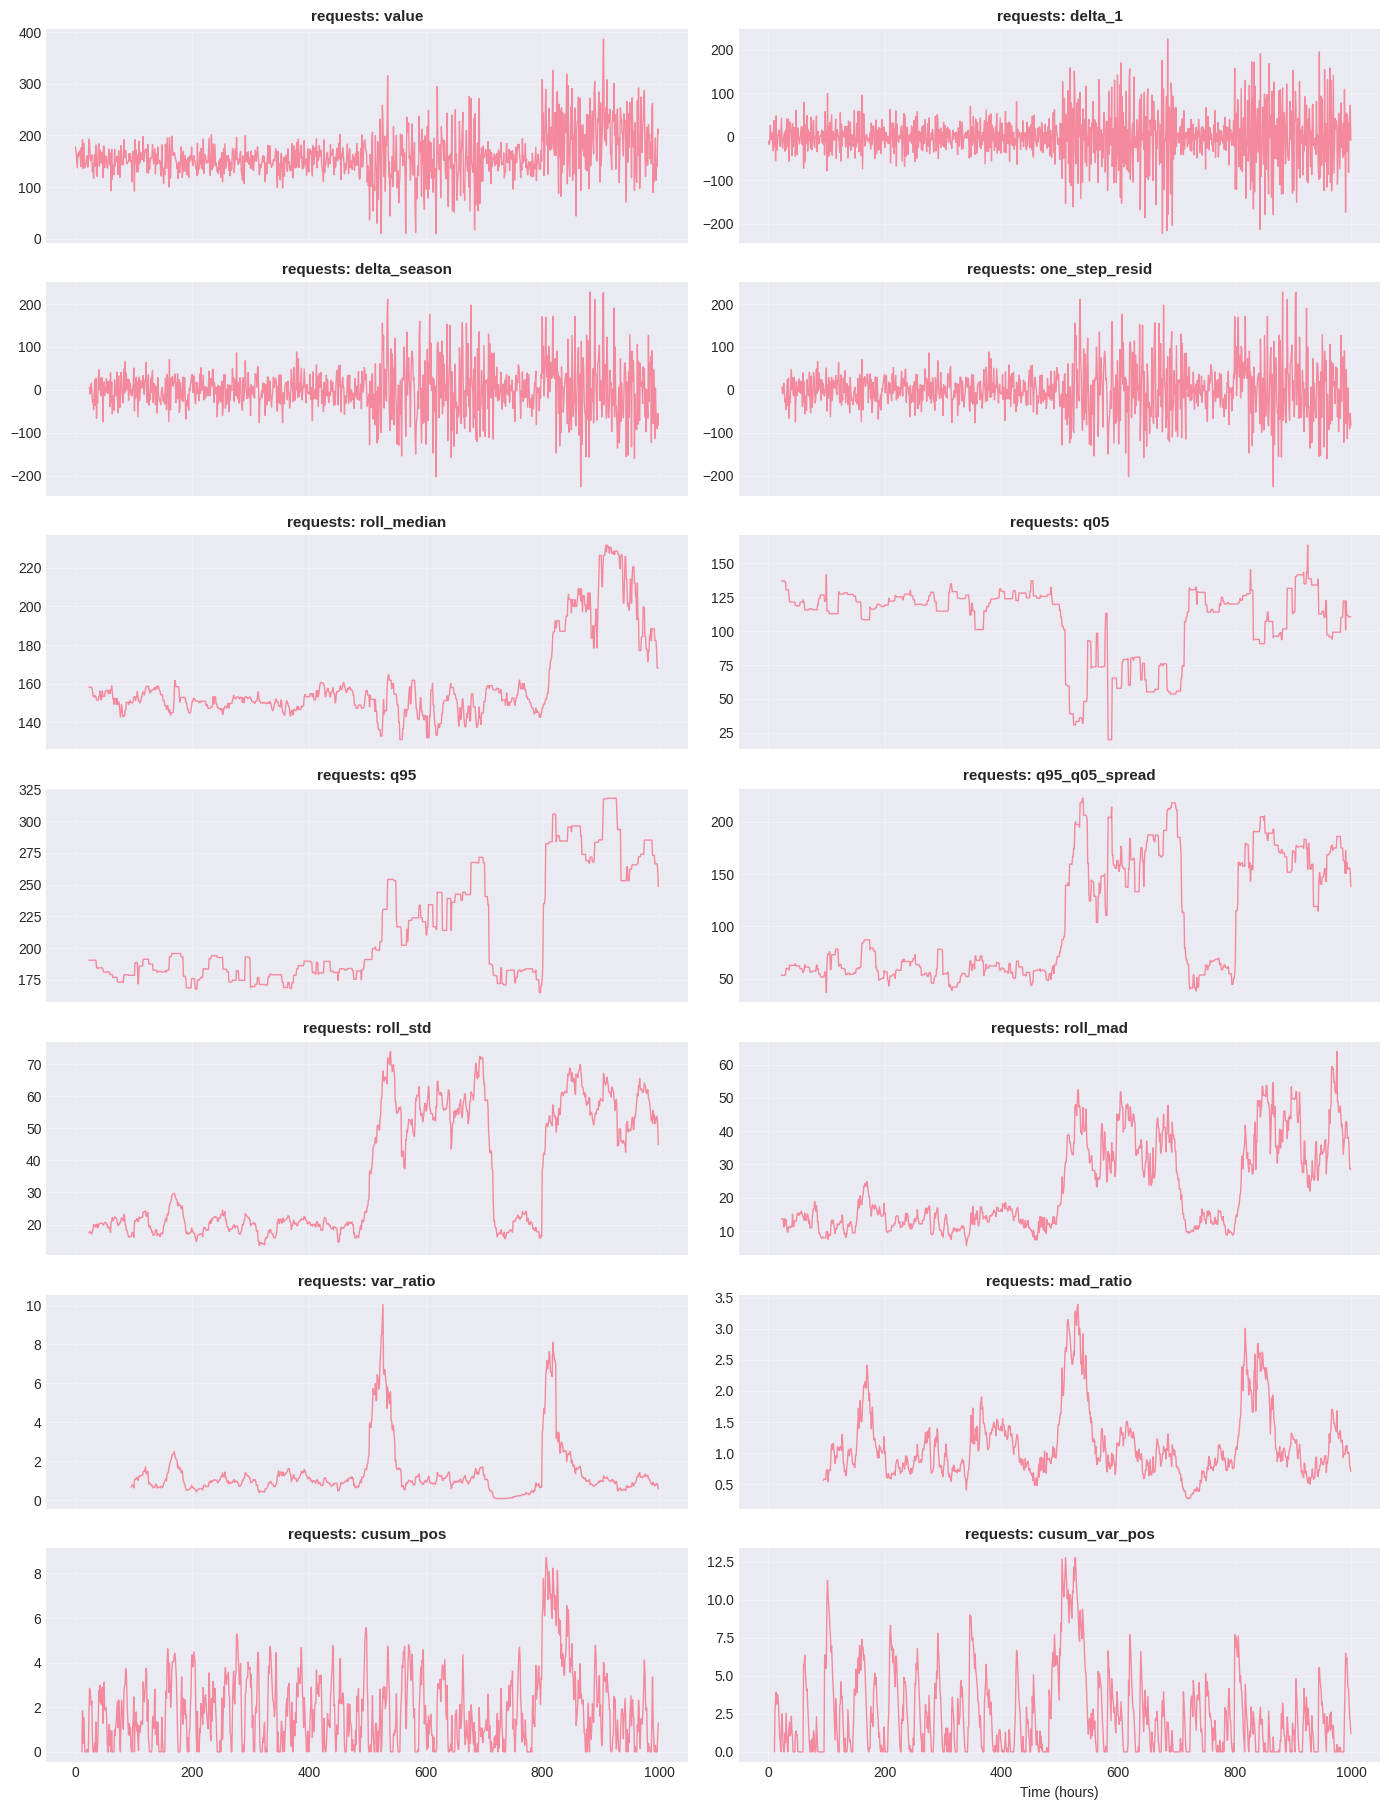

In [736]:
plot_metric_features(
    features_by_metric["response_time"],
    metric_name="requests",
    feature_cols=DEFAULT_FEATURES,
    ncols=2
)

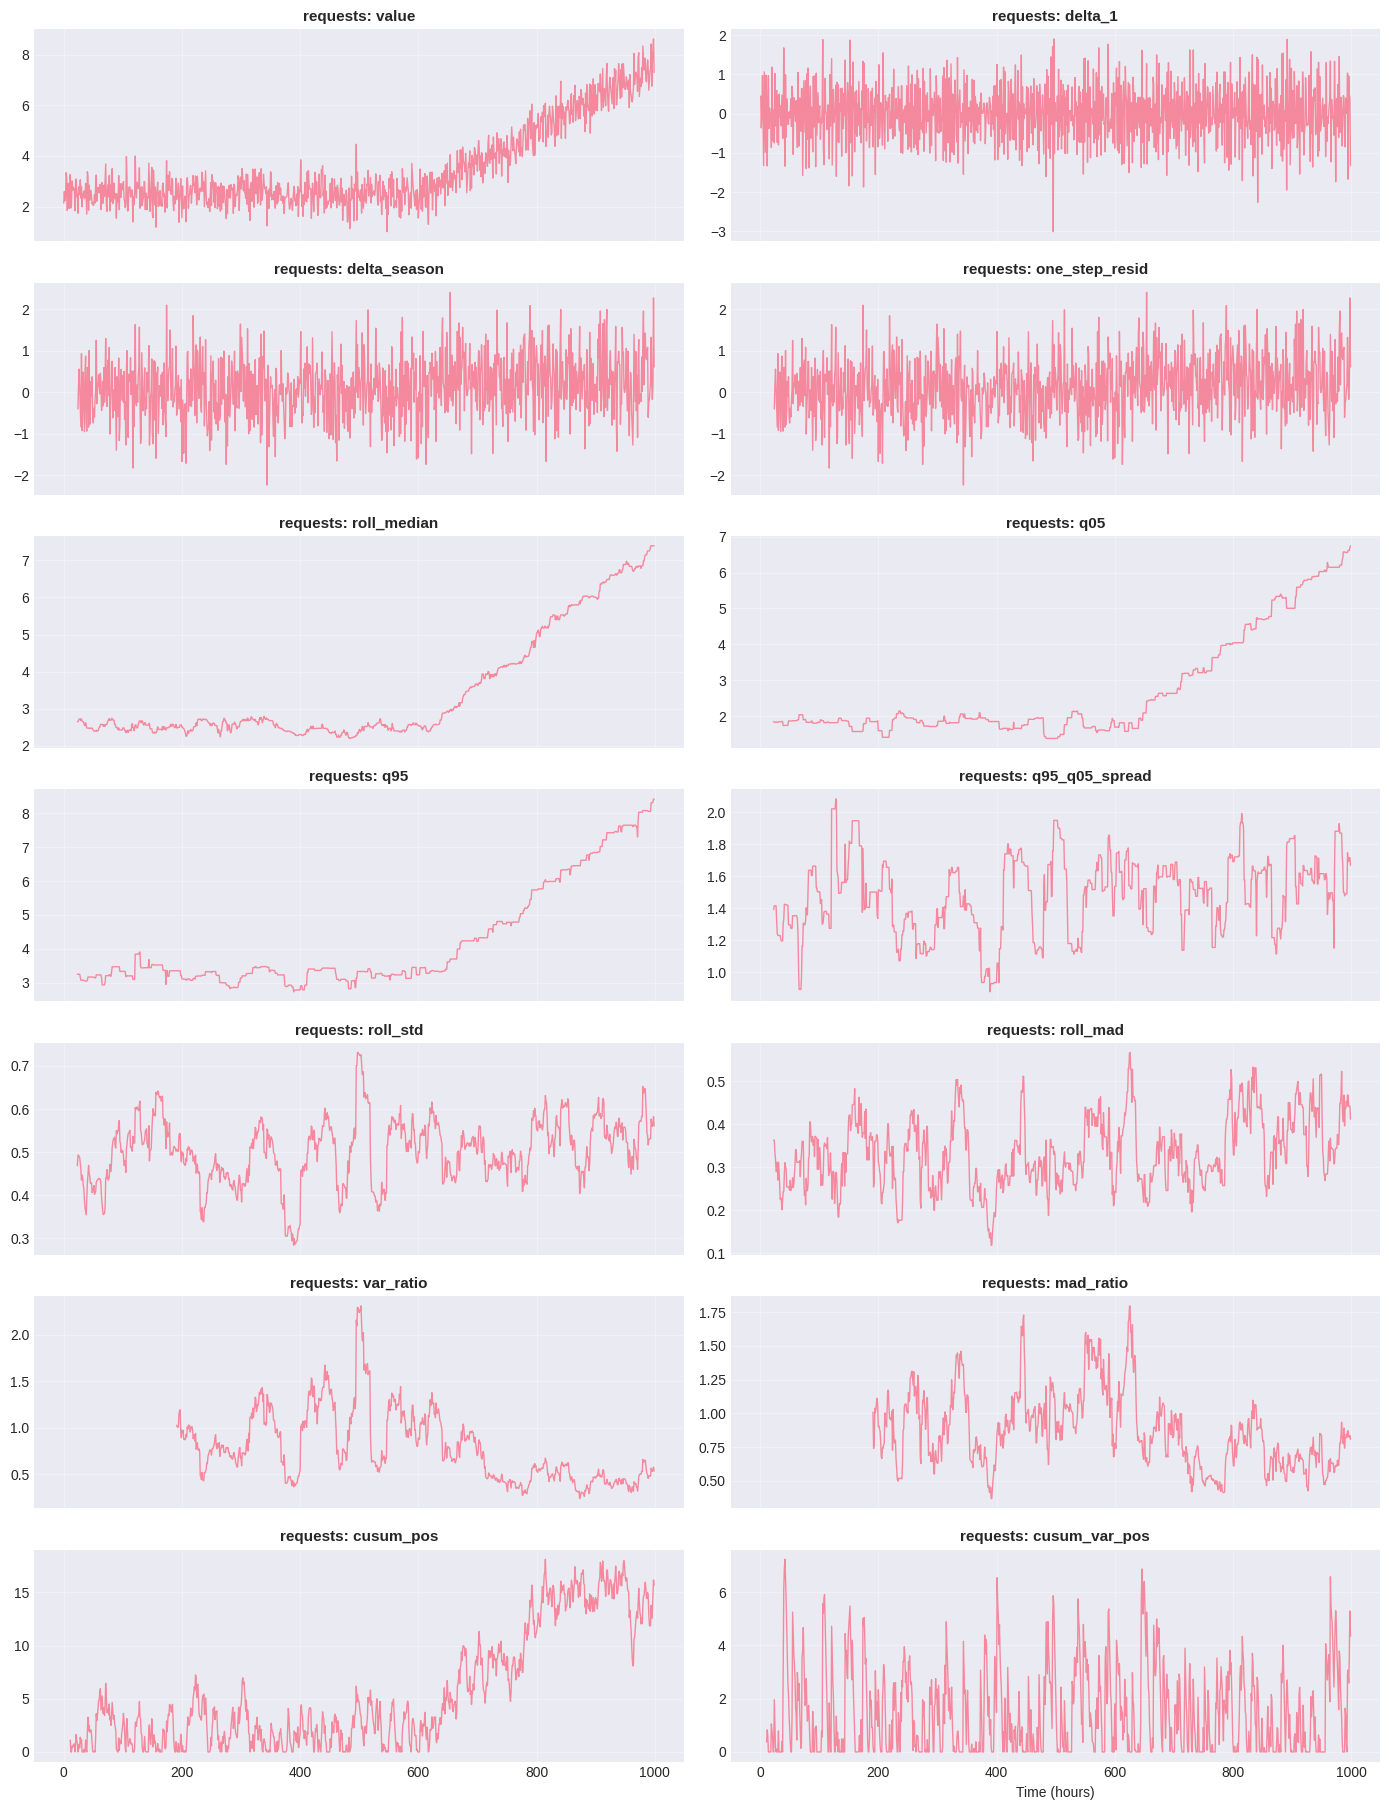

In [490]:
plot_metric_features(
    features_by_metric["error_rate"],
    metric_name="requests",
    feature_cols=DEFAULT_FEATURES,
    ncols=2
)

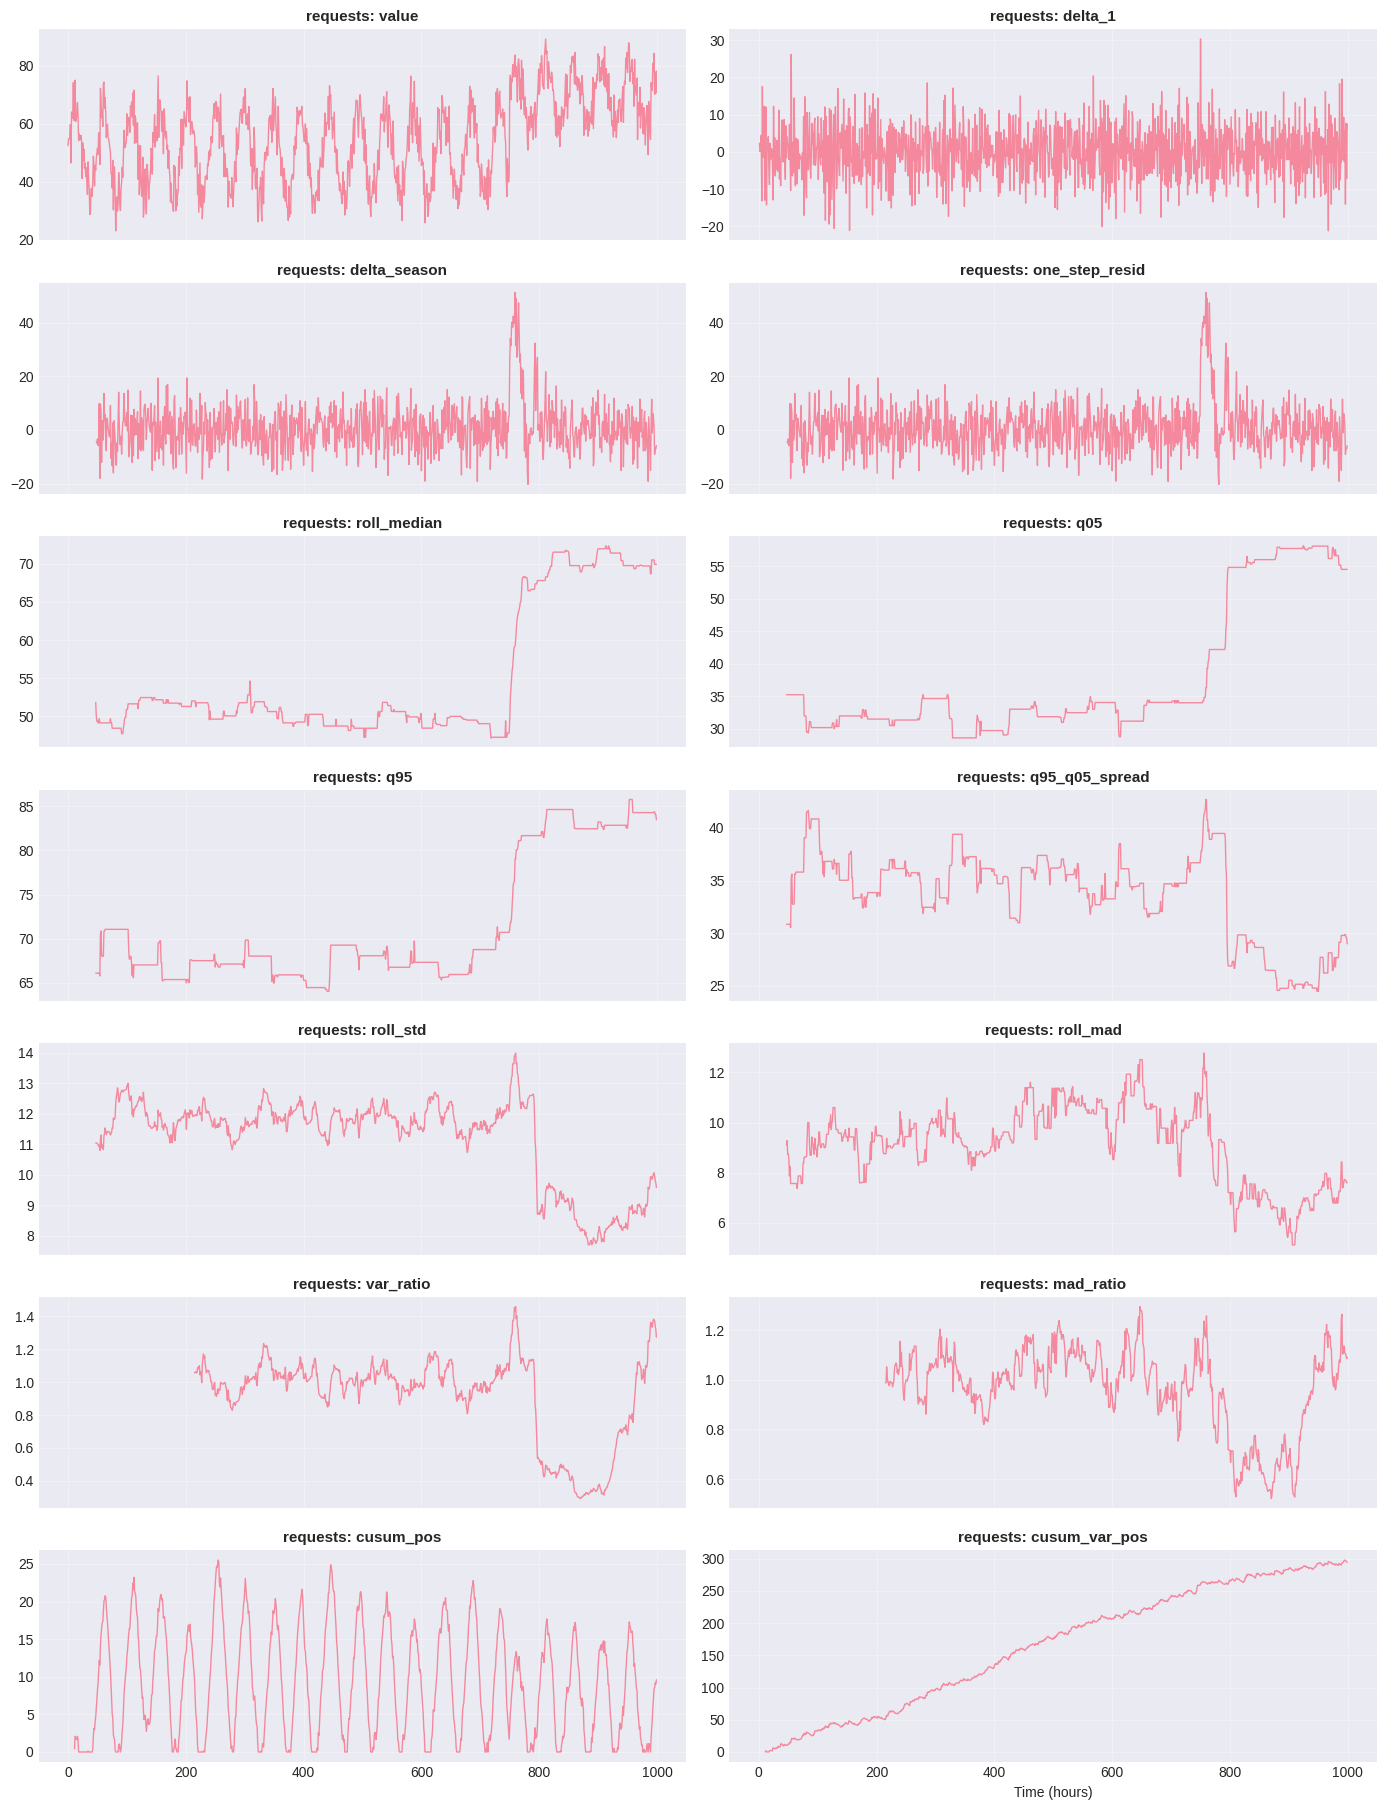

In [491]:
plot_metric_features(
    features_by_metric["cpu_usage"],
    metric_name="requests",
    feature_cols=DEFAULT_FEATURES,
    ncols=2
)

